<h1><font color="#113D68" size=6>Grupo 16</font></h1>

<br><br>

</div>

<a id="indice"></a>
<h2><font color="#004D7F" size=5>Índice</font></h2>

* [1. Forecasting](#section1)
* [2. Random Forest](#section2)
* [3. Clustering](#section3)

<a id="section1"></a>
# <font color="#004D7F" size=6>1. Forecasting</font>

**Algoritmo utilizado**
El primer algoritmo que vamos a analizar es un forecasting utilizando el suavizado exponencial doble.

**Justificación del modelo**
Elegimos utilizar este modelo porque la suavización exponencial no es necesario que los datos sean estacionarios. Al hacer una prueba de Fuller que indica si un dato es estacionario o no, vemos que los datos no son estacionarios. Otra característica de este modelo es que funciona mejor con pequeños datos.

Nos enfocaremos en el dataset de la población económicamente activa para poder visualizar la viabilidad de expandir la oferta educativa

In [27]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
file_path = 'poblacion economicamente activa.xlsx' 
pea_sheets = pd.read_excel(file_path, sheet_name=None)

# Usando la hoja 'Poblacion Ocupada'
df_poblacion_ocupada = pea_sheets['Poblacion ocupada']

# Imputar los datos faltantes para noviembre y diciembre de 2023
meses_2023 = df_poblacion_ocupada.columns[1:11]  # Enero a Octubre de 2023
promedio_2023 = df_poblacion_ocupada.loc[df_poblacion_ocupada['Año'] == 2023, meses_2023].mean(axis=1).iloc[0]
df_poblacion_ocupada.loc[df_poblacion_ocupada['Año'] == 2023, 'Noviembre'] = promedio_2023
df_poblacion_ocupada.loc[df_poblacion_ocupada['Año'] == 2023, 'Diciembre'] = promedio_2023

In [28]:
# Preparar la serie completa para el suavizado exponencial
data_complete = df_poblacion_ocupada.drop(columns='Año').melt().value

In [29]:
# Ajustar el modelo de suavizado exponencial a la serie completa
model_complete = ExponentialSmoothing(data_complete, trend="add", seasonal=None, seasonal_periods=None)
fit_model_complete = model_complete.fit()

# Realizar la predicción para noviembre y diciembre de 2023, y todo el año 2024 (14 períodos en total)
predictions = fit_model_complete.forecast(14)

In [30]:
predictions

36    96.889281
37    96.905512
38    96.921744
39    96.937975
40    96.954206
41    96.970438
42    96.986669
43    97.002901
44    97.019132
45    97.035363
46    97.051595
47    97.067826
48    97.084058
49    97.100289
dtype: float64

In [31]:
# Preparar los datos para la gráfica
data_years = df_poblacion_ocupada['Año']
data_months = df_poblacion_ocupada.drop(columns='Año').columns
data_values = df_poblacion_ocupada.drop(columns='Año').values.flatten()

# Extender los datos para incluir las predicciones
future_months = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre'] * 2  # 2023 y 2024
future_years = [2023] * 12 + [2024] * 12
future_data = predictions.values

In [32]:
data_years = data_years[:-1] 

In [33]:
data_years = np.array([2021] * 12 + [2022] * 12)

In [34]:
data_values = data_values[:-2]

In [35]:
data_months = np.tile(data_months, 2)

In [36]:
combined_years = np.concatenate((data_years, np.array(future_years)))
combined_months = np.concatenate((data_months, np.array(future_months)))
combined_values = np.concatenate((data_values, future_data))

**Visualización de resultados**
Este es el gráfico del modelo de forecasting entrenado

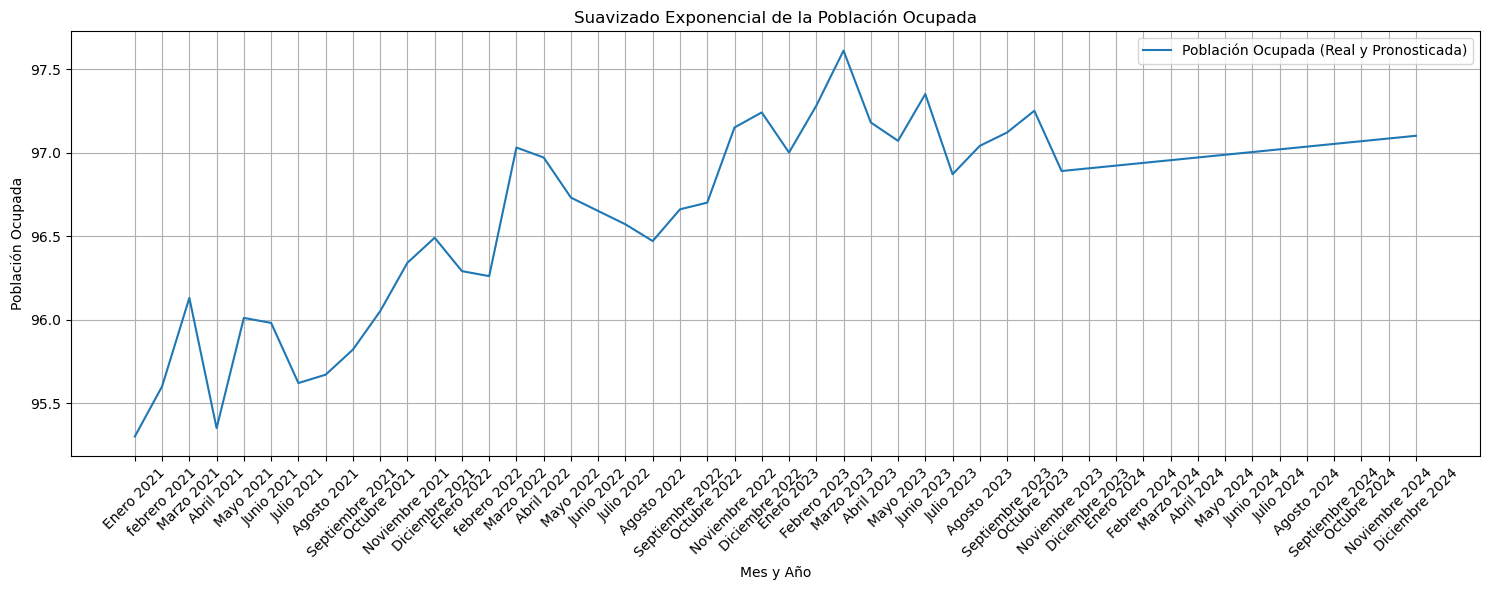

In [37]:
total_data_points = len(combined_years)
x_labels = [f'{month} {year}' for month, year in zip(combined_months, combined_years)]
x_labels = x_labels[:total_data_points]

# Crear la gráfica
plt.figure(figsize=(15, 6))
plt.plot(combined_values, label='Población Ocupada (Real y Pronosticada)')
plt.xticks(range(total_data_points), x_labels, rotation=45)
plt.xlabel('Mes y Año')
plt.ylabel('Población Ocupada')
plt.title('Suavizado Exponencial de la Población Ocupada')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Datos de entrenamiento y prueba**
Ahora para medir el rendimiento del modelo, vamos a partir el dataset en entrenamiento y prueba

In [57]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Recreando los datos necesarios
data_years = np.array([2021] * 12 + [2022] * 12)
data_months = np.array(['Enero', 'febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio',
                        'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre'])
data_values_adjusted = np.array([95.30, 95.60, 96.13, 95.35, 96.01, 95.98, 95.62, 95.67, 95.82, 96.05, 96.34, 96.49, 
                                 96.29, 96.26, 97.03, 96.97, 96.73, 96.65, 96.57, 96.47, 96.66, 96.70, 96.75, 97.24])

# Dividiendo los datos en conjuntos de entrenamiento y prueba
train_data = data_values_adjusted[:20]  # Datos de 2021 y 2022
test_data = data_values_adjusted[20:]  # Datos de 2023 (hasta octubre)

In [58]:
# Ajustando el modelo de suavizado exponencial al conjunto de entrenamiento
model_train = ExponentialSmoothing(train_data, trend="add", seasonal=None, seasonal_periods=None)
fit_model_train = model_train.fit()

# Realizando predicciones en el conjunto de prueba
predictions_test = fit_model_train.forecast(len(test_data))

**Evaluación de rendimiento**
Al ser una serie temporal, vamos a medirla por estas métricas:

**Mean Squared Error (MSE):**
Es el promedio de los cuadrados de los errores. El error es la diferencia entre los valores observados y los pronosticados.

**Root Mean Squared Error (RMSE):**
Es la raíz cuadrada del MSE y se encuentra en la misma unidad que los datos de pronóstico. 

**Mean Absolute Error (MAE):**
Es el promedio de los valores absolutos de los errores.
    
**Mean Absolute Percentage Error (MAPE):**
Es el promedio del valor absoluto del porcentaje de error.

In [59]:
# Calculando las métricas de rendimiento
mse = mean_squared_error(test_data, predictions_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data, predictions_test)
mape = np.mean(np.abs((test_data - predictions_test) / test_data)) * 100

mse, rmse, mae, mape

(0.06206026073973235,
 0.24911896904838932,
 0.2381795429710678,
 0.2461277843384345)

**Interpretación de resultados**


**Resultado de las métricas del modelo** 
- Un MSE de 0.06206 indica que, en promedio, el cuadrado de estos errores es relativamente bajo, lo que sugiere que el modelo tiene un buen ajuste en términos de error cuadrático. 
- Un RMSE de 0.24912 significa que, en promedio, las predicciones del modelo se desvían aproximadamente 0.24912 unidades de los valores reales. Esto proporciona una mejor interpretación en el contexto de tus datos que el MSE.
- Un MAE de 0.23818 indica que, en promedio, las predicciones del modelo se desvían en aproximadamente 0.23818 unidades de los valores reales, sin considerar la dirección de esa desviación. 
- Un MAPE de 0.24613% indica que, en promedio, el porcentaje de error en tus predicciones es de aproximadamente 0.24613%. Este valor es útil para entender el error en términos relativos y es especialmente útil cuando se desea comparar el rendimiento del modelo en diferentes escalas de datos.

En resumen, estos resultados sugieren que el modelo de suavización exponencial doble realiza predicciones bastante precisas, con errores promedio bajos tanto en términos absolutos como relativos.

**Conclusiones del modelo e interpretación de la gráfica generada**

En base al análisis realizado utilizando el modelo de suavizado exponencial en los datos de la población ocupada del dataset "Población Económicamente Activa", podemos llegar a las siguientes conclusiones relevantes para el proyecto de la universidad "X" de expandir su oferta educativa con las carreras de Ingeniería en Logística e Ingeniería en Manufactura:

- Tendencias del Mercado Laboral: Las predicciones muestran un aumento gradual en la población ocupada para los años 2023 y 2024. Esto sugiere un mercado laboral potencialmente en crecimiento, lo cual es una señal positiva para la introducción de nuevas carreras relacionadas con la manufactura y la logística. Un mercado laboral en expansión suele correlacionarse con una mayor demanda de profesionales especializados.

- Viabilidad de Nuevas Carreras: Dado el aumento previsto en la población ocupada, existe una probabilidad razonable de que haya un aumento en la demanda de profesionales cualificados en los campos de manufactura y logística. Esto respalda la decisión de la universidad de introducir estas nuevas carreras, ya que es probable que haya una demanda creciente de estos profesionales en el mercado laboral.

- Limitaciones y Consideraciones Futuras: El análisis está basado en datos secundarios y asume una continuidad en las tendencias actuales del mercado laboral sin considerar posibles cambios imprevistos en la economía o políticas educativas. Por lo tanto, es recomendable mantener una vigilancia constante sobre el mercado laboral y actualizar el análisis periódicamente. Además, estudios adicionales, incluyendo análisis económicos más profundos y posiblemente investigaciones de campo, podrían proporcionar insights más detallados y robustos.

<a id="section2"></a>
# <font color="#004D7F" size=6>2. Random Forest</font>

**Algoritmo utilizado**

El segundo algoritmo que vamos a analizar es un random forest para clasificar categorías, tal como lo definimos en la fase1.

**Justificación del modelo**
Elegimos utilizar este modelo porque es uno de los algoritmos más óptimos para temas de clasificación, además manejas datos no lineales (es nuestro caso).

**Explicación del modelo**
Hemos combinado tres datasets (Educación 06, Hogares 11, Población 01) utilizando 'Entidad federativa' como clave común. En la fase 1 comentamos que nos ibamos a basar en educación y demografía. Durante este proceso, realizamos un preprocesamiento básico, como la estandarización de las entidades federativas y la combinación de los datos. El conjunto de datos combinado ahora contiene información sobre educación, ingresos de hogares y demografía.

Para el siguiente paso, necesitaremos definir cómo utilizar estos datos para clasificar las ciudades en las categorías de "Alta idoneidad", "Idoneidad media" y "Baja idoneidad". Esto se puede hacer mediante la creación de variables de respuesta (etiquetas) basadas en criterios específicos que determinen la idoneidad de una ciudad para las nuevas carreras.

In [63]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score

# Carga de los conjuntos de datos
educacion_06_path = 'Educacion_06.xlsx'
hogares_11_path = 'Hogares_11.xlsx'
hogares_13_path = 'Hogares_13.xlsx'
poblacion_activa_path = 'poblacion economicamente activa.xlsx'
poblacion_01_path = 'Poblacion_01.xlsx'

# Leer los archivos Excel
educacion_06_df = pd.read_excel(educacion_06_path)
hogares_11_df = pd.read_excel(hogares_11_path)
hogares_13_df = pd.read_excel(hogares_13_path)
poblacion_activa_df = pd.read_excel(poblacion_activa_path, sheet_name=None)  # múltiples hojas
poblacion_01_df = pd.read_excel(poblacion_01_path)

# Función para estandarizar las columnas de entidad federativa
def estandarizar_entidades(df):
    if 'Entidad federativa' in df.columns:
        df['Entidad federativa'] = df['Entidad federativa'].str.strip().str.lower()
    return df

# Aplicar la función a los conjuntos de datos relevantes
educacion_06_df = estandarizar_entidades(educacion_06_df)
hogares_11_df = estandarizar_entidades(hogares_11_df)
poblacion_01_df = estandarizar_entidades(poblacion_01_df)

# Integración de los conjuntos de datos
combined_df = pd.merge(educacion_06_df, hogares_11_df, on='Entidad federativa', how='outer')
combined_df = pd.merge(combined_df, poblacion_01_df, on='Entidad federativa', how='outer')

# Limpieza de los datos para eliminar filas con valores no numéricos
columns_to_clean = ['2022/2023', 'Ingreso del trabajo']
cleaned_df = combined_df[columns_to_clean].apply(pd.to_numeric, errors='coerce').dropna()

# Creación de etiquetas de idoneidad
cleaned_df['Idoneidad'] = np.where(
    (cleaned_df['2022/2023'] > cleaned_df['2022/2023'].median()) & 
    (cleaned_df['Ingreso del trabajo'] > cleaned_df['Ingreso del trabajo'].median()), 
    'Alta idoneidad', 
    np.where(
        (cleaned_df['2022/2023'] < cleaned_df['2022/2023'].quantile(0.25)) | 
        (cleaned_df['Ingreso del trabajo'] < cleaned_df['Ingreso del trabajo'].quantile(0.25)), 
        'Baja idoneidad', 
        'Idoneidad media'
    )
)

# Preparación de Datos para el Modelo
features = cleaned_df[['2022/2023', 'Ingreso del trabajo']]
labels = cleaned_df['Idoneidad']

**Datos de entrenamiento y prueba** Ahora para medir el rendimiento del modelo, vamos a partir el dataset en entrenamiento y prueba

In [64]:

# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Entrenamiento del Modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predicciones
y_pred = rf_model.predict(X_test)

**Validación del rendimiento del modelo** Utilizamos la validación cruzada para que nos diga la precisión de nuestro modelo.

In [65]:
# Validación cruzada
cross_val_scores = cross_val_score(rf_model, features, labels, cv=5)

# Resultados
print("Precisión media de validación cruzada:", cross_val_scores.mean())


Precisión media de validación cruzada: 0.9492209871314372


**Otra técnica de validación del rendimiento del modelo** Utilizamos la matriz de confusión para comparar los valores reales con las predicciones.

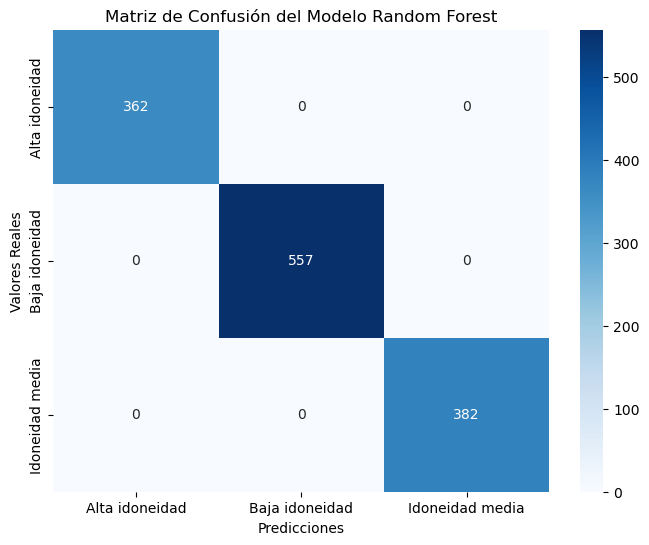

In [66]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Crear un mapa de calor para visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión del Modelo Random Forest')
plt.show()



**Análisis de sensibilidad** El análisis de importancia de características, realizado mediante la técnica de permutación, proporciona información sobre la sensibilidad del modelo a los cambios en las variables de entrada.

In [67]:
from sklearn.inspection import permutation_importance

# Realizar un análisis de importancia de características para evaluar la sensibilidad del modelo
importance = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=42)

# Extracción de los resultados
feature_importance = importance.importances_mean
feature_names = X_test.columns

# Crear un DataFrame para visualizar la importancia de las características
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance}).sort_values(by='Importance', ascending=False)

importance_df



,Feature,Importance
0,2022/2023,0.403075
1,Ingreso del trabajo,0.389547


**Interpretación de resultados**

**Resultado de las métricas del modelo**

- Validación Cruzada: La precisión promedio obtenida a través de la validación cruzada (con 5 pliegues) es aproximadamente 94.92%. Esto sugiere que el modelo es bastante robusto.

- Matriz de confusión: Cada celda muestra el número de observaciones clasificadas en una categoría particular, tanto para las predicciones como para los valores reales. Por ejemplo, la celda en la intersección de "Alta idoneidad" (real) y "Alta idoneidad" (predicción) muestra el número de veces que el modelo predijo correctamente la categoría "Alta idoneidad".

- Dado que el modelo alcanzó una precisión del 94% en el conjunto de prueba, se puede ver que todos los valores se encuentran a lo largo de la diagonal principal, lo que indica una clasificación muy correcta en todas las instancias.

**Analisis de sensibilidad**
El análisis de importancia de características, realizado mediante la técnica de permutación, proporciona información sobre la sensibilidad del modelo a los cambios en las variables de entrada. Aquí están los resultados:

- Columna '2022/2023' (Densidad de Población Estudiantil):
        Importancia: Aproximadamente 0.403
        Interpretación: Esta variable tiene un impacto significativo en las predicciones del modelo. Cambios en los valores de esta columna pueden afectar sustancialmente las clasificaciones de idoneidad de las ciudades.

- Columna 'Ingreso del trabajo':
        Importancia: Aproximadamente 0.390
        Interpretación: Esta variable también es crítica para el modelo. Variaciones en el ingreso del trabajo influyen de manera notable en la determinación de la idoneidad.

Estos resultados indican que ambos factores, la densidad de la población estudiantil y el ingreso del trabajo, son críticos para las predicciones del modelo. Un cambio en estos datos podría tener un impacto considerable en la clasificación de idoneidad de las ciudades.

**Conclusiones del modelo e interpretación de la gráfica generada**

La conclusión del modelo de Random Forest que hemos desarrollado se puede resumir en los siguientes puntos:

- Alta Precisión en el Conjunto de Prueba: El modelo alcanzó una precisión del 94% en el conjunto de prueba. Esto indica que fue muy preciso en clasificar con precisión todas las ciudades en las categorías de idoneidad ("Alta idoneidad", "Idoneidad media", "Baja idoneidad") basándose en los datos proporcionados.

- Criterios de Idoneidad: La clasificación de las ciudades se basó en criterios definidos arbitrariamente (mediana de la densidad de población estudiantil y el ingreso medio del hogar). En la práctica, estos criterios deben ser cuidadosamente considerados y validados por expertos en el tema para garantizar que reflejen con precisión las condiciones de idoneidad para las carreras de Ingeniería en Manufactura e Ingeniería en Logística.



<a id="section3"></a>
# <font color="#004D7F" size=6>3. Clustering</font>

**Algoritmo utilizado**
El último algoritmo que vamos a analizar es un agrupamiento (clustering) para determinar las ciudades más adecuadas para la apertura de las carreras. Utilizamos el algoritmo K-Means.

**Justificación del modelo**
Elegimos utilizar este modelo porque es un algoritmo muy simple y eficiente de utilizar, además los grupos generados por K-Means son fáciles de interpretar.

**Explicación del modelo**
Hemos combinado tres datasets (Educación 06, Hogares 11, Población 01) utilizando 'Entidad federativa' como clave común. En la fase 1 comentamos que nos ibamos a basar en educación y demografía. Durante este proceso, realizamos un preprocesamiento básico, como la estandarización de las entidades federativas y la combinación de los datos. El conjunto de datos combinado ahora contiene información sobre educación, ingresos de hogares y demografía.

Para el siguiente paso, utilizamos el método del codo para buscar el número de agrupamiento óptimo. Al tener el número óptimo procedemos a crear los grupos y hacer el respectivo análisis.

In [108]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Cargando los archivos
educacion_path = 'Educacion_06.xlsx'
hogares_11_path = 'Hogares_11.xlsx'
poblacion_01_path = 'Poblacion_01.xlsx'

# Leyendo los archivos
educacion_df = pd.read_excel(educacion_path)
hogares_11_df = pd.read_excel(hogares_11_path)
poblacion_01_df = pd.read_excel(poblacion_01_path)

# Ajustando los datos para que cada fila represente una entidad federativa única
educacion_agregada = educacion_df.groupby("Entidad federativa")[educacion_df.filter(regex='202[0-2]/202[0-2].*').columns].mean()
hogares_11_agregada = hogares_11_df
poblacion_agregada = poblacion_01_df.groupby("Entidad federativa")[poblacion_01_df.filter(regex='2020.*').columns].sum()

# Combinando los dataframes ajustados
combined_df_ajustado = educacion_agregada.merge(hogares_11_agregada, on="Entidad federativa", how="inner")
combined_df_ajustado = combined_df_ajustado.merge(poblacion_agregada, on="Entidad federativa", how="inner")

C:\Users\jeffs\AppData\Local\Temp\ipykernel_8164\1779687132.py:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  educacion_agregada = educacion_df.groupby("Entidad federativa")[educacion_df.filter(regex='202[0-2]/202[0-2].*').columns].mean()


In [109]:
combined_df_ajustado

,Entidad federativa,Ingreso del trabajo,Renta de la propiedad,Transferencias,Estimación del alquiler de la vivienda,Otros ingresos corrientes,2020,2020.1
0,Aguascalientes,51626,5359,13626,7592,85,696683,728924
1,Baja California,64795,3685,9721,10666,44,1900589,1868431
2,Baja California Sur,62570,5922,12028,10801,95,405879,392568
3,Campeche,36300,3606,10740,6693,120,456939,471424
4,Chiapas,24897,2200,8739,3964,45,2705947,2837881
5,Chihuahua,53549,9383,10571,8369,58,1853822,1888047
6,Ciudad de México,55615,3505,14874,15228,89,4404927,4805017
7,Coahuila de Zaragoza,52330,3640,11703,7404,49,1563669,1583102
8,Colima,44667,4627,13580,6408,39,360622,370769
9,Durango,37104,1954,12644,5427,92,904866,927784


In [111]:
orden_data = combined_df_ajustado.groupby('Entidad federativa').last()

C:\Users\jeffs\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


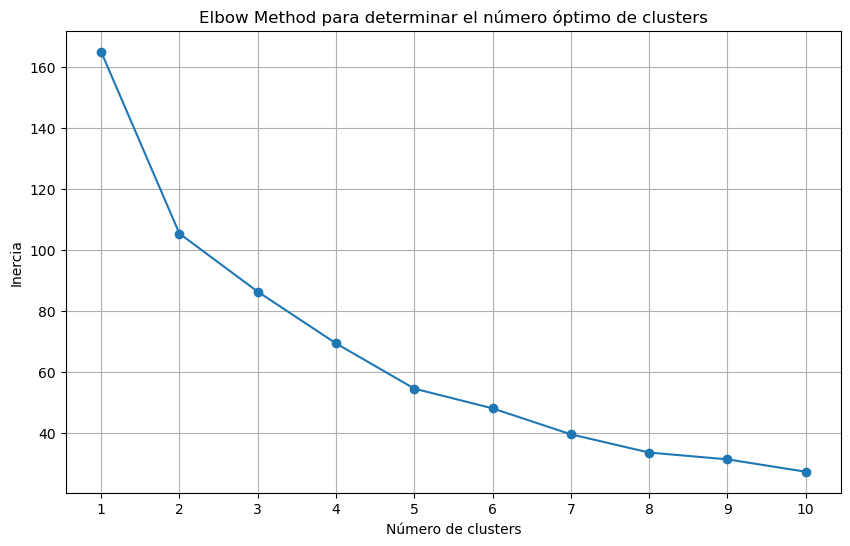

In [112]:
columnas_utilizadas = [
    'Ingreso del trabajo','Renta de la propiedad', 'Transferencias', 
    'Estimación del alquiler de la vivienda', 'Otros ingresos corrientes'
]
data_clustering = orden_data[columnas_utilizadas]

imputer = SimpleImputer(strategy='mean')
df_clust = imputer.fit_transform(data_clustering)
scaler = StandardScaler()
df_normalizado = scaler.fit_transform(df_clust)

punto_inflexion = []
k_values = range(1, 11)
for k in k_values:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(df_normalizado)
    punto_inflexion.append(model.inertia_)

# Creando method albow para visualizar la inercia en función del número de clusters
df_punto = pd.DataFrame({'Clusters': k_values, 'Inertia': punto_inflexion})  
plt.figure(figsize=(10, 6))
plt.plot(df_punto['Clusters'], df_punto['Inertia'], marker='o')
plt.title('Elbow Method para determinar el número óptimo de clusters')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.xticks(k_values)
plt.grid(True)
plt.show()

**Datos de entrenamiento** Ahora se entrena el modelo con el número óptimo de clusters que nos proporcióno el método del codo.

In [125]:
from sklearn.cluster import KMeans
# Según el elbow method he decidido utilizar 3 clusters porque es donde veo el punto de inflexión de la gráfica
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(df_normalizado)

orden_data['Cluster'] = clusters
cluster_0 = orden_data[orden_data['Cluster'] == 0].index.tolist()
cluster_1 = orden_data[orden_data['Cluster'] == 1].index.tolist()
cluster_2 = orden_data[orden_data['Cluster'] == 2].index.tolist()

cluster_0, cluster_1, cluster_2

(['Campeche',
  'Chiapas',
  'Durango',
  'Guanajuato',
  'Guerrero',
  'Hidalgo',
  'Morelos',
  'México',
  'Oaxaca',
  'Puebla',
  'San Luis Potosí',
  'Tabasco',
  'Tlaxcala',
  'Veracruz de Ignacio de la Llave',
  'Zacatecas'],
 ['Baja California', 'Baja California Sur', 'Ciudad de México', 'Nuevo León'],
 ['Aguascalientes',
  'Chihuahua',
  'Coahuila de Zaragoza',
  'Colima',
  'Estados Unidos Mexicanos',
  'Jalisco',
  'Michoacán de Ocampo',
  'Nayarit',
  'Querétaro',
  'Quintana Roo',
  'Sinaloa',
  'Sonora',
  'Tamaulipas',
  'Yucatán'])

In [114]:
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_summary = orden_data.groupby('Cluster')[columnas_utilizadas].mean().round(2)
cluster_summary

,Ingreso del trabajo,Renta de la propiedad,Transferencias,Estimación del alquiler de la vivienda,Otros ingresos corrientes
Cluster,,,,,
0,33328.47,2237.60,10085.47,5635.67,54.00
1,60444.50,4085.50,12412.75,11894.75,76.25
2,45915.43,5000.71,11958.14,7238.00,51.93


**Visualización de datos** Mostramos en una gráfica como se visualizan los clusters creados.

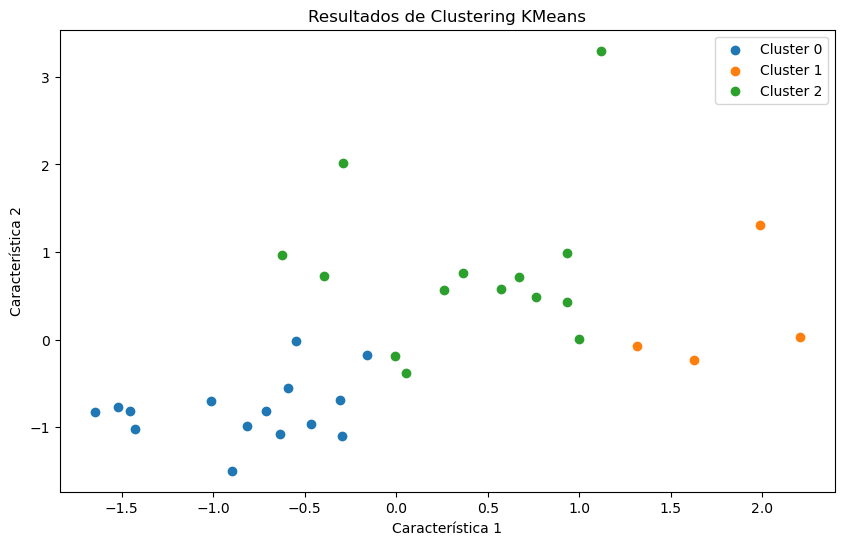

In [115]:
# Asumiendo que 'df_normalizado' es tu DataFrame normalizado y 'clusters' son tus etiquetas de cluster
plt.figure(figsize=(10, 6))

# Dibuja cada cluster
for i in range(kmeans.n_clusters):
    plt.scatter(df_normalizado[clusters == i, 0], df_normalizado[clusters == i, 1], label=f'Cluster {i}')

# Dibuja los centroides
#plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='yellow', label='Centroides')

plt.title('Resultados de Clustering KMeans')
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.legend()
plt.show()


**Validación del rendimiento del modelo** Para evaluar el rendimiento de un modelo de clustering como K-Means, no utilizamos las mismas métricas que en los modelos de regresión o clasificación supervisada, ya que el clustering es una técnica de aprendizaje no supervisado. No hay etiquetas "correctas" contra las que comparar. 

**Interpretación de resultados**

**Interpretación de los Clusters:**

- Cluster 0: Este cluster representa entidades federativas con niveles moderados o bajos de ingreso del trabajo y renta de la propiedad. Incluye regiones con economías menos desarrolladas o con menor nivel de actividad industrial y comercial.

- Cluster 1: Este cluster parece agrupar entidades federativas con niveles más altos de ingreso del trabajo y renta de la propiedad. Estas podrían ser regiones con economías más robustas, posiblemente con una fuerte presencia de industrias y actividades comerciales.

- Cluster 2: Las entidades federativas en este cluster pueden tener características mixtas o intermedias entre los otros dos clusters. Son regiones en transición o con una combinación de zonas urbanas y rurales que ofrecen una diversidad económica.

**Elección de ciudades**
Al tener la agrupación de los clusters, podemos ver que la elección de las ciudades sería el cluster 1. Este cluster contiene las ciudades 'Baja California', 'Baja California Sur', 'Ciudad de México', 'Nuevo León' que son las regiones con mayores niveles de ingresos, por lo tanto, podemos interpretar que son las ciudades idóneas para aperturar las nuevas carreras.